In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE

from cli import get_file_paths
import plot
import pipeline

In [4]:
avail = np.arange(0, 720, 3) + 3
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]
reset_24

array([  3,   6,   9,  12,  15,  18,  24,  30,  36,  45,  48,  60,  72,
        90,  96, 120, 144, 180, 240, 288, 360, 480, 720])

In [5]:
cycle_lengths = reset_24
percent_ons = [1/3]
specific_dc_tag = "30of30"

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['bin_size'] = '30'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = False
pipeline_params["save_presence_dc_comparisons"] = False
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

In [6]:
site_key = 'Carp'
type_key = 'LF'
print(site_key, type_key)

data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key

file_paths = get_file_paths(data_params)
file_paths

Carp LF


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_Carp_call_classes.csv',
 'bd2_TYPE_SITE_YEAR': 'bd2__LFCarp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LFCarp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LFCarp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LFCarp_summary',
 'simulated_schemes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled/simulated_schemes',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activi

In [7]:
def assemble_initial_location_summary(file_paths):
    """
    Puts together all bd2 outputs in data/raw and converts detection start_times to datetime objects.
    Returns and saves a summary of bd2-detected bat calls within a desired frequency band.
    """

    location_df = dd.read_csv(f'{file_paths["raw_SITE_folder"]}/*.csv', dtype=str).compute()
    location_df['low_freq'] = location_df['low_freq'].astype('float')
    location_df['high_freq'] = location_df['high_freq'].astype('float')
    file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
    anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S')

    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)

    return location_df

def add_frequency_groups_to_summary_using_thresholds(location_df, file_paths, data_params, save=True):
    
    location_df.insert(0, 'freq_group', '')
    groups = FREQ_GROUPS[data_params['site_tag']]
    blue_group = groups['LF1']
    red_group = groups['HF1']
    yellow_group = groups['HF2']

    call_is_yellow = (location_df['low_freq']>=yellow_group[0])&(location_df['high_freq']<=yellow_group[1])
    call_is_red = (location_df['low_freq']>=red_group[0])&(location_df['high_freq']<=red_group[1])
    call_is_blue = (location_df['low_freq']>=blue_group[0])&(location_df['high_freq']<=blue_group[1])

    location_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
    location_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
    location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'

    if data_params['type_tag'] != '':
        location_df = location_df.loc[location_df['freq_group']==data_params['type_tag']]

    if save:
        location_df.to_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv')

    return location_df

def add_frequency_groups_to_summary_using_kmeans(location_df, file_paths, data_params, save=True):

    location_df.insert(0, 'kmeans_classes', '')
    location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
    kept_calls_from_location = location_df.iloc[location_classes['index_in_summary'].values].copy()
    kept_calls_from_location['kmeans_classes'] = location_classes['KMEANS_CLASSES'].values

    if data_params['type_tag'] != '':
        kept_calls_from_location = kept_calls_from_location.loc[kept_calls_from_location['kmeans_classes']==data_params['type_tag']]

    if save:
        kept_calls_from_location.to_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv')

    return kept_calls_from_location

In [8]:
if (pipeline_params['assemble_location_summary']):
    init_location_sum = assemble_initial_location_summary(file_paths) 
    init_location_sum.reset_index(inplace=True)
    init_location_sum.rename({'index':'index_in_file'}, axis='columns', inplace=True)
    if pipeline_params['use_threshold_to_group']:
        location_sum = add_frequency_groups_to_summary_using_thresholds(init_location_sum.copy(), file_paths, data_params) ## Use to update any bd2__(location summary).csv files
    if pipeline_params['use_kmeans_to_group']:
        location_sum = add_frequency_groups_to_summary_using_kmeans(init_location_sum.copy(), file_paths, data_params) 

In [9]:
location_sum

,kmeans_classes,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
0,LF,0,2022-07-13 04:53:00.335500,2022-07-13 04:53:00.335500,2022-07-13 04:53:00.353200,1380.3355,1380.3532,28046.0,31703.0,Echolocation,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,008,1795
1,LF,1,2022-07-13 04:55:13.597500,2022-07-13 04:55:13.597500,2022-07-13 04:55:13.612900,1513.5975,1513.6129,23750.0,28075.0,Echolocation,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,008,1795
2,LF,2,2022-07-13 04:55:13.823500,2022-07-13 04:55:13.823500,2022-07-13 04:55:13.839600,1513.8235,1513.8396,23750.0,28002.0,Echolocation,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,008,1795
3,LF,3,2022-07-13 04:55:13.988500,2022-07-13 04:55:13.988500,2022-07-13 04:55:14.001000,1513.9885,1514.001,24609.0,30884.0,Echolocation,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,008,1795
4,LF,4,2022-07-13 04:55:14.267500,2022-07-13 04:55:14.267500,2022-07-13 04:55:14.283900,1514.2675,1514.2839,23750.0,28526.0,Echolocation,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,008,1795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016308,LF,49,2022-10-17 07:56:42.025500,2022-10-17 07:56:42.025500,2022-10-17 07:56:42.039100,1602.0255,1602.0391,25468.0,30005.0,Echolocation,Nyctalus leisleri,0.432,0.599,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,010,<NA>
1016309,LF,50,2022-10-17 07:56:42.396500,2022-10-17 07:56:42.396500,2022-10-17 07:56:42.410600,1602.3965,1602.4106,25468.0,28304.0,Echolocation,Nyctalus leisleri,0.454,0.541,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,010,<NA>
1016310,LF,0,2022-10-17 09:20:50.849500,2022-10-17 09:20:50.849500,2022-10-17 09:20:50.857300,1250.8495,1250.8573,44375.0,52935.0,Echolocation,Pipistrellus pipistrellus,0.404,0.564,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,010,<NA>
1016311,LF,1,2022-10-17 09:20:51.841500,2022-10-17 09:20:51.841500,2022-10-17 09:20:51.852100,1251.8415,1251.8521,42656.0,60216.0,Echolocation,Pipistrellus pipistrellus,0.305,0.556,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,010,<NA>


In [10]:
location_sum_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
location_sum_df

,kmeans_classes,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
0,LF,0,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.353200000,1380.3355,1380.3532,28046.0,31703.0,Echolocation,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
1,LF,1,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.612900000,1513.5975,1513.6129,23750.0,28075.0,Echolocation,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
2,LF,2,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.839600000,1513.8235,1513.8396,23750.0,28002.0,Echolocation,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
3,LF,3,2022-07-13 04:55:13.988500000,2022-07-13 04:55:13.988500000,2022-07-13 04:55:14.001000000,1513.9885,1514.0010,24609.0,30884.0,Echolocation,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
4,LF,4,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.283900000,1514.2675,1514.2839,23750.0,28526.0,Echolocation,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016308,LF,49,2022-10-17 07:56:42.025500000,2022-10-17 07:56:42.025500000,2022-10-17 07:56:42.039100000,1602.0255,1602.0391,25468.0,30005.0,Echolocation,Nyctalus leisleri,0.432,0.599,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016309,LF,50,2022-10-17 07:56:42.396500000,2022-10-17 07:56:42.396500000,2022-10-17 07:56:42.410600000,1602.3965,1602.4106,25468.0,28304.0,Echolocation,Nyctalus leisleri,0.454,0.541,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016310,LF,0,2022-10-17 09:20:50.849500000,2022-10-17 09:20:50.849500000,2022-10-17 09:20:50.857300000,1250.8495,1250.8573,44375.0,52935.0,Echolocation,Pipistrellus pipistrellus,0.404,0.564,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN
1016311,LF,1,2022-10-17 09:20:51.841500000,2022-10-17 09:20:51.841500000,2022-10-17 09:20:51.852100000,1251.8415,1251.8521,42656.0,60216.0,Echolocation,Pipistrellus pipistrellus,0.305,0.556,-1,/mnt/ubna_data_02/recover-20221017/UBNA_010/20...,Carp Pond,recover-20221017,10,NaN


In [11]:
activity_dets_arr = pd.DataFrame()

# for dc_tag in data_params['dc_tags']:
dc_tag = data_params['cur_dc_tag']
print(dc_tag)
location_df = ss.prepare_summary_for_plotting_with_duty_cycle(file_paths, dc_tag, data_params['bin_size'])
num_of_detections = actvt.get_number_of_detections_per_interval(location_df, data_params)
dc_dets = actvt.construct_activity_arr_from_location_summary(num_of_detections, dc_tag, file_paths, data_params)
dc_dets = dc_dets.set_index("datetime_UTC")
activity_dets_arr = pd.concat([activity_dets_arr, dc_dets], axis=1)


activity_dets_arr

30of30


,num_dets (30of30)
datetime_UTC,
2022-07-13 00:00:00,0.0
2022-07-13 00:30:00,0.0
2022-07-13 01:00:00,0.0
2022-07-13 01:30:00,0.0
2022-07-13 02:00:00,0.0
...,...
2022-10-17 13:30:00,0.0
2022-10-17 14:00:00,0.0
2022-10-17 14:30:00,0.0


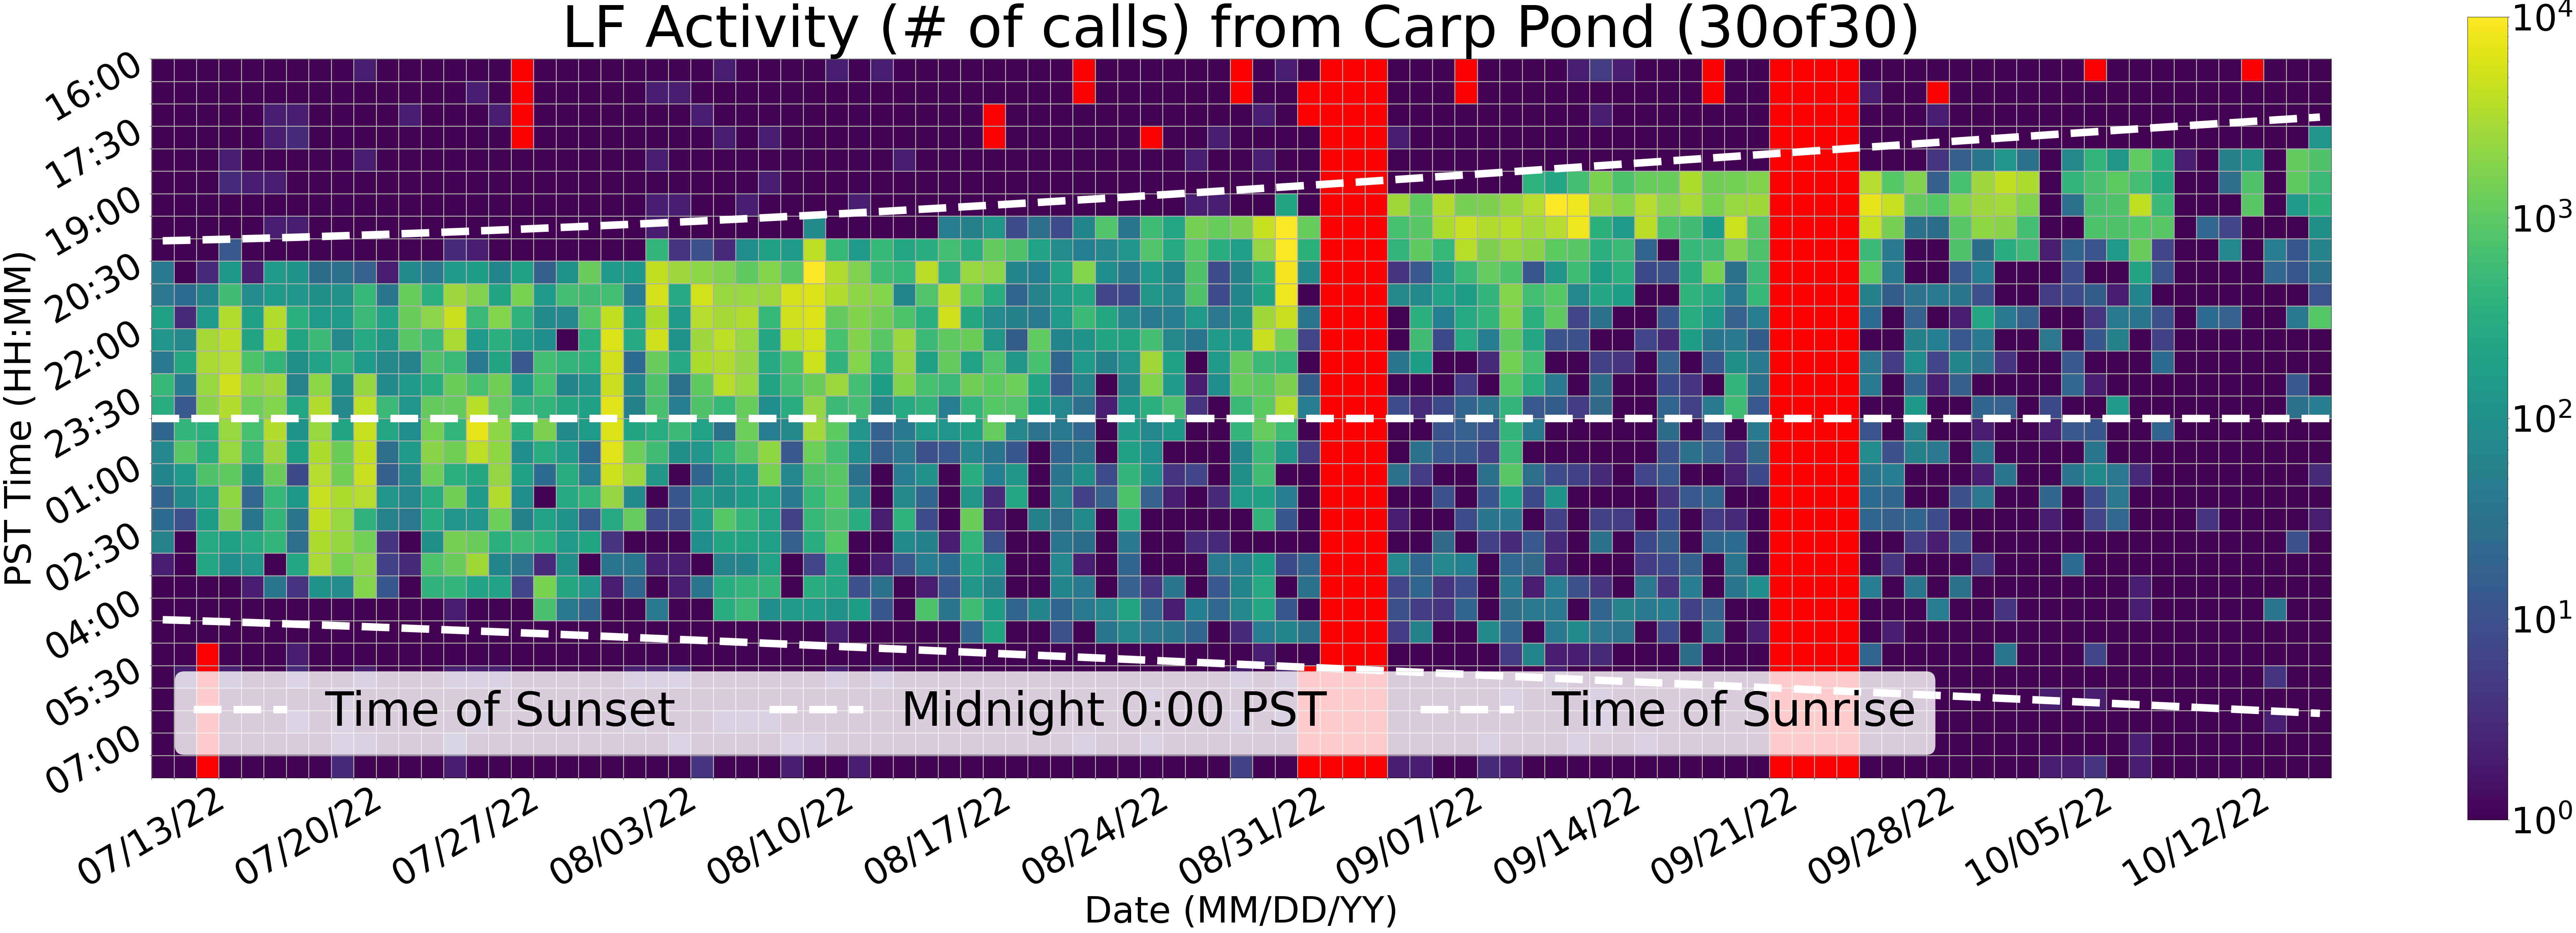

In [12]:
plot.plot_activity_grid_for_dets(activity_dets_arr, data_params, pipeline_params, file_paths)